# Quick start

**Welcome to `bruges`!

This library does all sorts of things so it's hard to show you a single workflow and say, "here's how to use `bruges`". But making a simple wedge model will let us show you several features, and maybe it will help you see how to use `bruges` in your own work.

Seismic wedge models provide seismic interpreters a quantitative way of studying thin-bed stratigraphy at or below seismic resolution. Here's the workflow:

1. Define the layer geometries.
1. Give those layers rock properties.
1. Calculate reflection coefficients.
1. Make a seismic wavelet.
1. Model the seismic response by convolving the reflectivities with the wavelet. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bruges as bg

## Make a wedge

The `wedge` function in `models` submodule allows you to generate a variety of stratigraphic geometries. The default gives us a model `m` which is a 2-D NumPy array of size `(100, 100)`. It has 3 layers in it.

In [2]:
m, top, base, ref = bg.models.wedge()

The `wedge` function returns a tuple containing the model `m`, as well as the a `top`, `base` and `ref` denoting some key boundaries in the model. Let's put these objects on a plot.

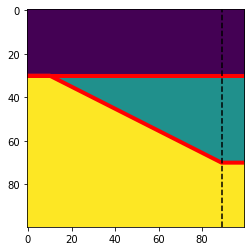

In [3]:
plt.imshow(m)
plt.plot(top, 'r', lw=4)
plt.plot(base, 'r', lw=4)
plt.axvline(ref, c='k', ls='--')
plt.show()

The model `m` is a 2-D NumPy array where each element is an index corresponding to each layer. The purple layer region has `0`, the green layer has `1` and the yellow layer is `2` . `top` and `base`, shown in red, are the depths down to the "top" of wedge layer and "base" of the wedge layer respectively. `ref` stands for "reference trace" and it denotes the position where the wedge has a thickness factor of 1.

## Fill it with rock properties

Let's define P-wave velocity, S-wave velocity, and rho (density) for our 3 rock types:

In [4]:
vps = np.array([2320, 2350, 2350])
vss = np.array([1150, 1250, 1200])
rhos = np.array([2650, 2600, 2620])

We can use these to make `vp` and `rho` earth models. We can use NumPy's fancy indexing by passing our array of indicies to access the rock properties (in this case acoustic impedance) for every element at once. 

In [5]:
vp = vps[m]
vs = vss[m]
rho = rhos[m]

And plot the acoustic impedance to check it looks reasonable:

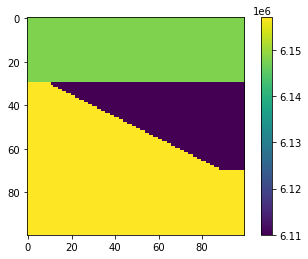

In [6]:
plt.imshow(vp*rho, interpolation='none')
plt.colorbar()
plt.show()

Or calculate the elastic impedance for a given angle `theta1`, say 10 degrees:

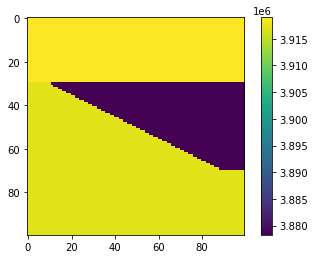

In [7]:
ei10 = bg.rockphysics.elastic_impedance(vp, vs, rho, theta1=10,)

plt.imshow(ei10.T, interpolation='none')
plt.colorbar()
plt.show()

## Calculate acoustic reflectivity

We can create a section of normal incidence reflection coefficient. This will be what we convolve with a wavelet. 

Bruges can calculate the acoustic reflectivity:

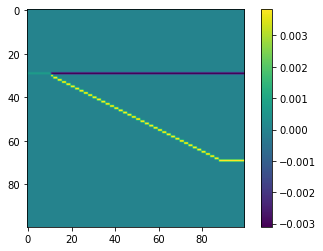

In [48]:
rc = bg.reflection.acoustic_reflectivity(vp, rho)

plt.imshow(rc)
plt.colorbar()
plt.show()

The reflections coeffients are zero almost everywhere, except at the layer boundaries. The reflection coefficient between layer 1 and layer 2 is a negative, and between layer 2 and layer 3 is a positive number. This will determine the scale and polarity of the seismic amplitudes. 

## Offset reflectivity

We can also calculate the exact Zoeppritz offset reflectivity. For example, to compute the reflectivity at 10 degrees of offset &mdash; note that this results in complex numbers, so we'll only use the real part in the plot:

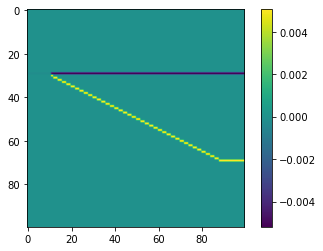

In [49]:
rc10 = bg.reflection.reflectivity(vp, vs, rho, theta=10)

plt.imshow(rc10.real)
plt.colorbar()
plt.show()

###### Create a wavelet

Let's create a Ricker wavelet to serve as our seismic pulse. We specify it has a length of 0.256 s, a sample interval of 0.002 s, and corner frequencies of 8, 12, 20, and 40 Hz:

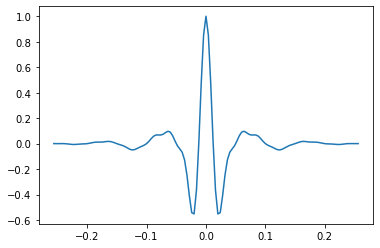

In [55]:
w, t = bg.filters.ormsby(0.512, 0.004, [8, 12, 20, 40])

plt.plot(t, w)

There are several wavelet functions; they can all take a sequence of frequencies and produce all of them at once as a filter bank:

Text(0, 0.5, 'frequency [Hz]')

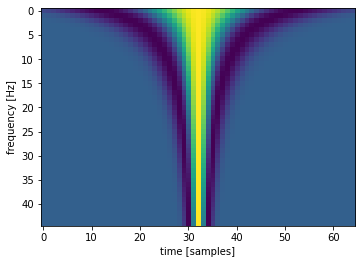

In [56]:
w_, t = bg.filters.ricker(0.256, 0.004, np.arange(5, 50))

plt.imshow(w_)
plt.xlabel('time [samples]')
plt.ylabel('frequency [Hz]')

## Convolve the wavelet with the reflectivity

We can use `np.convolve` to perform the convolution. Let's look at a single waveform from the reference location `ref` in our model. The synthetic seismic trace is band-limited filtering of the reflectivity spikes. When these spikes get closer together the waveforms will "tune" with one another and won't line up with the reflectivity series.

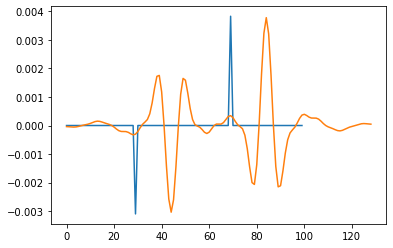

In [59]:
rc_ref = rc[:, ref]
syn = np.convolve(rc_ref, w, mode='same')

plt.plot(rc_ref)
plt.plot(syn)
plt.show()

## Create a synthetic section


We can apply this convolution operation over all the reflectivity series in our section using NumPy's `apply_along_axis` function.

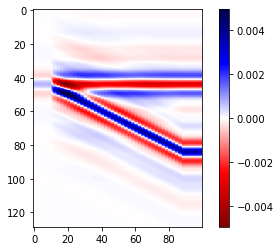

In [60]:
syn = np.apply_along_axis(np.convolve, arr=rc, axis=0, v=w, mode='same')

ma = np.percentile(syn, 99.9)
plt.imshow(syn, cmap='seismic_r', vmin=-ma, vmax=ma)
plt.colorbar()
plt.show()